In [1]:
###############################################################################
# Adapted from huggingface implementation of textual inversion                #
###############################################################################
from accelerate.utils import write_basic_config
write_basic_config()
from google.colab import drive
drive.mount('/content/drive')
pretrained_model_name_or_path = "stabilityai/stable-diffusion-2"
# We will generate images from prompots like "a photo of a hazelnut with mysks_hole"
# The unique word here is mysks_hole, for which a new embedding will be learned
images_path = '/content/drive/MyDrive/DefectSpectrum/DS-MVTec/hazelnut/image/crack'

Mounted at /content/drive


In [2]:
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

In [3]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [5]:
class TextualInversionDataset(Dataset):
    def __init__(
        self,
        data_root,
        tokenizer,
        learnable_property="object",  # [object, style]
        size=512,
        repeats=100,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
        placeholder_token="S*",
        center_crop=False,
    ):

        self.data_root = data_root
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.size = size
        self.placeholder_token = placeholder_token
        self.center_crop = center_crop
        self.flip_p = flip_p

        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)]

        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if set == "train":
            self._length = self.num_images * repeats

        self.interpolation = {
            #"linear": PIL.Image.Resampling.LINEAR,
            "bilinear": PIL.Image.Resampling.BILINEAR,
            "bicubic": PIL.Image.Resampling.BICUBIC,
            "lanczos": PIL.Image.Resampling.LANCZOS,
        }[interpolation]
        imagenet_templates_small = [
            "a photo of a hazelnut with a {}",
            "a rendering of a hazelnut with a {}",
            "a cropped photo of the hazelnut with a {}",
            "the photo of a hazelnut with a {}",
            "a dark photo of the hazelnut with a {}",
            "a close-up photo of a hazelnut with a {}",
            "a bright photo of the hazelnut with a {}",
            "a photo of the hazelnut with a {}",
            "a photo of a hazelnut with one {}",
            ]

        self.templates = imagenet_style_templates_small if learnable_property == "style" else imagenet_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        image = Image.open(self.image_paths[i % self.num_images])

        if not image.mode == "RGB":
            image = image.convert("RGB")

        placeholder_string = self.placeholder_token
        text = random.choice(self.templates).format(placeholder_string)

        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]

        # default to score-sde preprocessing
        img = np.array(image).astype(np.uint8)

        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            h, w, = (
                img.shape[0],
                img.shape[1],
            )
            img = img[(h - crop) // 2 : (h + crop) // 2, (w - crop) // 2 : (w + crop) // 2]

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)

        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)
        return example

In [ ]:
def initialize_networks(
    pretrained_model_name_or_path,
    placeholder_token='S*',
    initializer_tocken='hazelnut',
):
  """
  Creates the text_encoder, vae, unet and the noise scheduler networks.
  """
  tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
  )
  ##################
  # Text Encoder   #
  ##################
  # Add the placeholder token in tokenizer
  num_added_tokens = tokenizer.add_tokens(placeholder_token)
  if num_added_tokens == 0:
      raise ValueError(
          f"The tokenizer already contains the token {placeholder_token}. Please pass a different"
          " `placeholder_token` that is not already in the tokenizer."
      )
  token_ids = tokenizer.encode(initializer_token, add_special_tokens=False)
  # Check if initializer_token is a single token or a sequence of tokens
  if len(token_ids) > 1:
      raise ValueError("The initializer token must be a single token.")
  initializer_token_id = token_ids[0]
  placeholder_token_id = tokenizer.convert_tokens_to_ids(placeholder_token)
  text_encoder = CLIPTextModel.from_pretrained(
      pretrained_model_name_or_path, subfolder="text_encoder"
  )
  #To account for the newly added token(s)
  text_encoder.resize_token_embeddings(len(tokenizer))
  #Initialize the embedding of new token with the closest initializer token identified.
  token_embeds = text_encoder.get_input_embeddings().weight.data
  token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

  ##############################
  # VAE, Unet, noise scheduler #
  ##############################
  vae = AutoencoderKL.from_pretrained(
      pretrained_model_name_or_path, subfolder="vae"
  )
  unet = UNet2DConditionModel.from_pretrained(
      pretrained_model_name_or_path, subfolder="unet"
  )
  noise_scheduler = DDPMScheduler.from_config(
      pretrained_model_name_or_path, subfolder="scheduler"
  )

  return tokenizer, text_encoder, vae, unet, noise_scheduler

In [4]:
what_to_teach = "object"
placeholder_token = "mysks_crack"
initializer_token = "crack" #Since we want images of hazelnut with a crack defect, for which we learn a new embedding
tokenizer, text_encoder, vae, unet, noise_scheduler = initialize_networks(pretrained_model_name_or_path, placeholder_token, initializer_token)

In [7]:
def freeze_params(params):
    for param in params:
        param.requires_grad = False

# Freeze vae and unet
freeze_params(vae.parameters())
freeze_params(unet.parameters())
# Freeze all parameters except for the token embeddings in text encoder
params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
freeze_params(params_to_freeze)

In [10]:
train_dataset = TextualInversionDataset(
      data_root='/content/drive/MyDrive/DefectSpectrum/DS-MVTec/hazelnut/image/crack',
      tokenizer=tokenizer,
      size=vae.sample_size,
      placeholder_token=placeholder_token,
      repeats=20,
      learnable_property=what_to_teach, #Option selected above between object and style
      center_crop=False,
      set="train",
)
def create_dataloader(train_batch_size=1):
    return torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

<ipython-input-10-bdd479554639>:4: FutureWarning: Accessing config attribute `sample_size` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'sample_size' over 'AutoencoderKL's config object instead, e.g. 'unet.config.sample_size'.
  size=vae.sample_size,


In [11]:
hyperparameters = {
    "learning_rate": 1e-05,
    "scale_lr": True,
    "max_train_steps": 2000,
    "save_steps": 200,
    "train_batch_size": 4,
    "gradient_accumulation_steps": 1,
    "gradient_checkpointing": True,
    "mixed_precision": "fp16",
    "seed": 42,
    "output_dir": "/content/drive/MyDrive/textualinversion"
}

In [12]:
def save_progress(text_encoder, placeholder_token_id, accelerator, save_path):
    #logger.info("Saving embeddings")
    learned_embeds = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id]
    learned_embeds_dict = {placeholder_token: learned_embeds.detach().cpu()}
    torch.save(learned_embeds_dict, save_path)

def training_function(text_encoder, vae, unet):
    train_batch_size = hyperparameters["train_batch_size"]
    gradient_accumulation_steps = hyperparameters["gradient_accumulation_steps"]
    learning_rate = hyperparameters["learning_rate"]
    max_train_steps = hyperparameters["max_train_steps"]
    output_dir = hyperparameters["output_dir"]
    gradient_checkpointing = hyperparameters["gradient_checkpointing"]

    accelerator = Accelerator(
        gradient_accumulation_steps=gradient_accumulation_steps,
        mixed_precision=hyperparameters["mixed_precision"]
    )

    if gradient_checkpointing:
        text_encoder.gradient_checkpointing_enable()
        unet.enable_gradient_checkpointing()

    train_dataloader = create_dataloader(train_batch_size)

    if hyperparameters["scale_lr"]:
        learning_rate = (
            learning_rate * gradient_accumulation_steps * train_batch_size * accelerator.num_processes
        )

    # Initialize the optimizer
    optimizer = torch.optim.AdamW(
        text_encoder.get_input_embeddings().parameters(),  # only optimize the embeddings
        lr=learning_rate,
    )

    text_encoder, optimizer, train_dataloader = accelerator.prepare(
        text_encoder, optimizer, train_dataloader
    )

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # Move vae and unet to device
    vae.to(accelerator.device, dtype=weight_dtype)
    unet.to(accelerator.device, dtype=weight_dtype)

    # Keep vae in eval mode as we don't train it
    vae.eval()
    # Keep unet in train mode to enable gradient checkpointing
    unet.train()


    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

    print("***** Running training *****")
    print(f"  Num examples = {len(train_dataset)}")
    print(f"  Instantaneous batch size per device = {train_batch_size}")
    print(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    print(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
    print(f"  Total optimization steps = {max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        text_encoder.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(text_encoder):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample().detach()
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states.to(weight_dtype)).sample

                 # Get the target for loss depending on the prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                loss = F.mse_loss(noise_pred, target, reduction="none").mean([1, 2, 3]).mean()
                accelerator.backward(loss)

                # Zero out the gradients for all token embeddings except the newly added
                # embeddings for the concept, as we only want to optimize the concept embeddings
                if accelerator.num_processes > 1:
                    grads = text_encoder.module.get_input_embeddings().weight.grad
                else:
                    grads = text_encoder.get_input_embeddings().weight.grad
                # Get the index for tokens that we want to zero the grads for
                index_grads_to_zero = torch.arange(len(tokenizer)) != placeholder_token_id
                grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)

                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1
                if global_step % hyperparameters["save_steps"] == 0:
                    save_path = os.path.join(output_dir, f"learned_embeds-step-{global_step}.bin")
                    save_progress(text_encoder, placeholder_token_id, accelerator, save_path)

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= max_train_steps:
                break

        accelerator.wait_for_everyone()


    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        #pipeline = StableDiffusionPipeline.from_pretrained(
            #pretrained_model_name_or_path,
            #text_encoder=accelerator.unwrap_model(text_encoder),
            #tokenizer=tokenizer,
            #vae=vae,
            #unet=unet,
        #)
        #pipeline.save_pretrained(output_dir)
        # Also save the newly trained embeddings
        save_path = os.path.join(output_dir, f"learned_embeds.bin")
        save_progress(text_encoder, placeholder_token_id, accelerator, save_path)

In [ ]:
import accelerate
accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet))

for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
  if param.grad is not None:
    del param.grad  # free some memory
  torch.cuda.empty_cache()

Launching training on one GPU.
***** Running training *****
  Num examples = 1800
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 2000


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


In [ ]:
from diffusers import DPMSolverMultistepScheduler
pipe = StableDiffusionPipeline.from_pretrained(
    hyperparameters["output_dir"],
    scheduler=DPMSolverMultistepScheduler.from_pretrained(hyperparameters["output_dir"], subfolder="scheduler"),
    torch_dtype=torch.float16,
).to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [14]:
pipe = StableDiffusionPipeline.from_pretrained(
    pretrained_model_name_or_path,
    torch_dtype=torch.float16
).to("cuda")
pipe.load_textual_inversion('/content/drive/MyDrive/textualinversion/learned_embeds-step-800.bin')

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

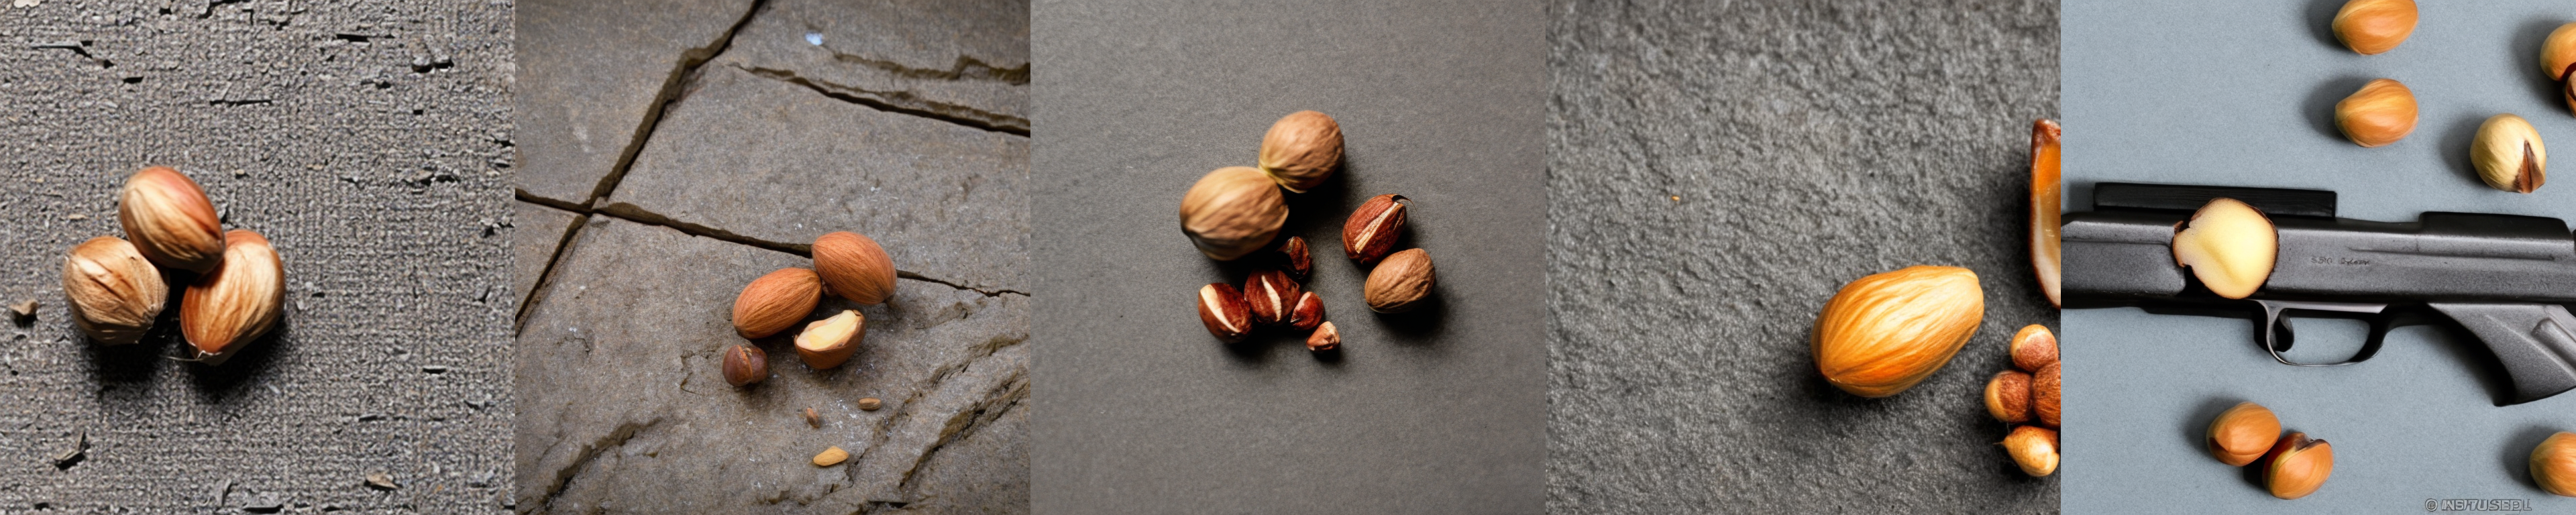

In [15]:
prompt = "a photo of a single hazelnut with a sks_crack"
num_samples = 5
num_rows = 1

all_images = []
for _ in range(num_rows):
    images = pipe([prompt] * num_samples, num_inference_steps=50, guidance_scale=8.5).images
    all_images.extend(images)

grid = image_grid(all_images, num_rows, num_samples)
grid